# Comparison Script for Our Algorithm and A pre_trained Deep neural network 

### Imports

In [1]:
import os
from skimage import io, transform 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin
from skimage.io import imshow
import time
from utils import *
import tensorflow as tf 
from tensorflow import keras 
from cvzone.HandTrackingModule import HandDetector

2024-12-22 11:42:16.233436: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 11:42:16.401197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 11:42:16.425762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-22 11:42:16.435761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 11:42:16.569640: I tensorflow/core/platform/cpu_feature_guar

## Utility Functions

In [2]:
def RGBtoYCbCr (R, G, B):
    R = int(R)
    G = int(G)
    B = int(B)
    R /= 255.0
    G /= 255.0
    B /= 255.0
    Y = 16 + (65.481 * R + 128.553 * G + 24.966 * B)
    Cb = 128 + (-37.797 * R - 74.203 * G + 112.0 * B)
    Cr = 128 + (112.0 * R - 93.786 * G - 18.214 * B)
    return Y, Cb, Cr

In [3]:
def our_model_train(path = './Skin_NonSkin.txt'):
    content = ""
    with open(path, 'r') as file:
        content = file.read()
    entries = content.split('\n')
    dataset = dict()
    for line in entries:
        if line:
            R, G, B, label = line.split()
            label = int(label)
            if(label not in dataset):
                dataset[label] = []
            Y, Cb, Cr = RGBtoYCbCr(R, G, B)
            dataset[label].append([Cb, Cr])
            
    return dataset

In [4]:
def get_mean_cov(dataset):
    mean = dict()
    cov = dict()
    for label in dataset:
        data = np.array(dataset[label])
        mean[label] = np.mean(data, axis=0)
        cov[label] = np.cov(data, rowvar=False)
    return mean, cov

In [5]:
def prob_c_label(C, mean, cov):
    C = np.array(C)
    mean = np.array(mean)
    cov = np.array(cov)
    
    C_diff = C - mean
    inv_cov = np.linalg.inv(cov)
    
    log_det = np.log(np.linalg.det(cov))
    
    log_norm_factor = 0.5 * (log_det + C.shape[1] * np.log(2 * np.pi))
    
    x = np.einsum('ijk,kl,ijl->ij', C_diff, inv_cov, C_diff)
    
    log_prob = -0.5 * x - log_norm_factor
    
    prob = np.exp(log_prob)
    
    return prob

In [6]:
def prob_skin_c(C, skin_mean, skin_cov, non_skin_mean, non_skin_cov):
    prob_c_skin = prob_c_label(C, skin_mean, skin_cov)
    prob_c_non_skin = prob_c_label(C, non_skin_mean, non_skin_cov)

    return prob_c_skin / (prob_c_skin + prob_c_non_skin)

In [7]:
def appendFaceContour(frame, resized_size, contour_areas, smallest_contours):
    original_height, original_width = frame.shape[:2]
    scale_x = resized_size[0] / original_width
    scale_y = resized_size[1] / original_height
    faces = face_cascade.detectMultiScale(frame, 1.3, 5)
    global max_face
    global max_area_face
    if len(faces) > 0:
        max_area = 0
        for (x, y, w, h) in faces:
            area = w * h
            if area > max_area and (max_area_face == 0 or abs(area - max_area_face) < 0.3 * max_area_face):
                max_area = area
                max_face = (x, y, w, h)
                max_area_face = max_area
    if max_face:
        (x, y, w, h) = max_face
        face = frame.copy()
        cv2.rectangle(face, (x, y), (x + w, y + h), (0, 255, 0), 2)
        radius = min(w, h) // 2 
        center_x = x + w // 2
        center_y = y + h // 2
        cv2.circle(face, (center_x, center_y), radius, (0, 255, 0), 2)
        cv2.imshow('face', face)
        x_resized = int(x * scale_x)
        y_resized = int(y * scale_y)
        w_resized = int(w * scale_x)
        h_resized = int(h * scale_y)
        middle_x = x_resized + w_resized // 2
        middle_y = y_resized + h_resized // 2
        for _, contour in contour_areas[-min(2,len(contour_areas)):]: 
            temp = contour.reshape(-1, 2)
            min_x = min(temp[:, 0])
            max_x = max(temp[:, 0])
            min_y = min(temp[:, 1])
            max_y = max(temp[:, 1])
            if (middle_x >= min_x and middle_x <= max_x) and (middle_y >= min_y and middle_y <= max_y):
                smallest_contours.append(contour)
    elif len(contour_areas) > 1:
        smallest_contours.append(contour_areas[-2][1])

In [8]:
def removeContours(mask, frame, resized_size):
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((20, 5)), iterations=3)
    contours = cv2.findContours(closed_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    contour_areas = [(cv2.contourArea(c), c) for c in contours]
    contour_areas.sort(key=lambda x: x[0]) 
    smallest_contours = [c[1] for c in contour_areas[:-min(2, len(contour_areas))]]
    ### can be removed
    if len(contour_areas) > 1 and contour_areas[-2][0] < contour_areas[-1][0] / 2:
        smallest_contours.append(contour_areas[-2][1])
    ### can be removed
    maybe_face = contour_areas[-min(2, len(contour_areas)):]
    
    appendFaceContour(frame, resized_size, maybe_face, smallest_contours)
    if len(smallest_contours) > 0:
        cv2.drawContours(mask, smallest_contours, -1, 0, -1)
    image = mask.copy()
    for x in contours[-min(2,len(contours)):]:
        cv2.drawContours(image, [x], -1, (0, 0, 255), 2)
    cv2.imshow('contours', image)


In [9]:
def cleanMask(skin_mask, frame, resized_size):
    binary_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=3)
    binary_mask = cv2.threshold(binary_mask, 0.005, 1, cv2.THRESH_BINARY)[1]
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=3)
    # binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3, 3)), iterations=3)
    removeContours(binary_mask, frame, resized_size)
    return binary_mask

In [10]:
def removeFaceMask(image, face_cascade):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    mask = np.ones((image.shape[0], image.shape[1]), dtype=np.uint8)
    
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]  # Create grid of indices
    for (x, y, w, h) in faces:
        center_x, center_y = x + w // 2, y + h // 2  
        radius = 1.1 * (max(w, h) // 2 ) 
        
        dist_from_center = (X - center_x)**2 + (Y - center_y)**2
        circular_mask = dist_from_center <= radius**2
        
        mask[circular_mask] = 0
    
    return mask

In [11]:
def select_color_from_fingertip(x, y):
    global drawing_color
    for (x1, y1, x2, y2), color in color_squares.items():
        if x1 <= x <= x2 and y1 <= y <= y2:
            drawing_color = color
            break

In [12]:
dataset = our_model_train()
mean, cov = get_mean_cov(dataset)
skin_mean = mean[1]
skin_cov = cov[1]
non_skin_mean = mean[2]
non_skin_cov = cov[2]
max_face = None
max_area_face = 0

drawing_color = (0, 0, 255)

color_squares = {
    (10, 10, 50, 50): (255, 0, 0), 
    (60, 10, 110, 50): (0, 255, 0), 
    (120, 10, 170, 50): (0, 0, 255), 
}

In [13]:
def import_data():
    train_img = [] 
    train_label = [] 
    test_img = [] 
    test_label = [] 
    i = 0
    # Debug single image from test directory
    test_dir = 'archive/fingers/test'
    for f in os.listdir(test_dir):
        if f.endswith('.png'):  # Ensure only process image files
            i += 1
            if i > 200:
                break
            img = io.imread(os.path.join(test_dir, f))  # Use full path
            img = transform.resize(img, (480, 640), anti_aliasing=True)
            if len(img.shape) == 2:  # Grayscale image
                img = np.stack([img] * 3, axis=-1)
            test_img.append(img)
            test_label.append(f[-6])  # Extract label
            

    # Debug single image from train directory
    #train_dir = 'archive/fingers/train'
    #for f in os.listdir(train_dir):
    #    if f.endswith('.png'):  # Ensure only process image files
    #        img = io.imread(os.path.join(train_dir, f))  # Use full path
    #        img = transform.resize(img, (128, 128), anti_aliasing=True)
    #        train_img.append(img)
    #        
    #        train_label.append(f[-6])  # Extract label
            
            
    return np.array(test_img), np.array(test_label)


In [14]:
x_test, y_test = import_data()
y_test = np.copy(y_test.astype(int))

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePl

In [16]:
print(f"xtest: {x_test.shape}")
print(f"ytest: {y_test.shape}")

xtest: (200, 480, 640, 3)
ytest: (200,)


In [18]:
print(y_test[0])

1


### Pre-trained NN

In [19]:
detector = HandDetector(maxHands=1, detectionCon=0.8)

I0000 00:00:1734860604.469080    4170 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734860604.470848    5029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.3), renderer: Mesa Intel(R) Iris(R) Plus Graphics (ICL GT2)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1734860604.536513    5017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734860604.551346    5021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [20]:
def pre_trained_detection(img):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    hands = detector.findHands(img, draw=False)  
    if hands:  
        hand = hands[0]
        if hand:    
            lmlist = hand[0]['lmList']
            fingerup = detector.fingersUp(hand[0])  
            finger_count = sum(fingerup)  
            return finger_count
        else:
            return 0

In [21]:
correct = 0
for i in range(len(y_test)):
    finger_test = pre_trained_detection(x_test[i])
    if finger_test == y_test[i]:
        correct += 1
print(correct)

W0000 00:00:1734860606.663240    5022 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


176


### Our Processing

In [26]:
def our_detection(frame):
    resizing_size_X = 512
    resizing_size_Y = 512
    resizing_size = (resizing_size_X, resizing_size_Y)
    #frame = cv2.flip(frame, 1)
    try:
        plt.imshow(frame)
        faceMask = np.ones((frame.shape[0], frame.shape[1]))
        # faceMask = removeFaceMask(frame, face_cascade)
        original = frame.copy()

        print(np.max(frame))
        frame = np.multiply(frame, faceMask[:, :, np.newaxis])
        frame = frame.astype(np.uint8)
        frame = cv2.resize(frame, resizing_size)
        #cv2.imshow('Original Frame', frame)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        YCC = cv2.cvtColor(frame, cv2.COLOR_RGB2YCrCb)
        frame = frame.astype(np.float64) / 255
        C = YCC[:, :, 1:]

        skin_mask = prob_skin_c(C, skin_mean, skin_cov, non_skin_mean, non_skin_cov)
        #cv2.imshow('Skin Mask before cleaning wiz threshold',  cv2.threshold(skin_mask, 0.75, 1, cv2.THRESH_BINARY)[1])

        hand_mask = cleanMask(skin_mask, original, resizing_size)

        if hand_mask.dtype != np.uint8:
            hand_mask = (hand_mask * 255).astype(np.uint8)

        skeleton = skeletonize(hand_mask)
        try:
            finger_count = count_fingers(hand_mask)
        except:
            finger_count = 0

        return finger_count
        logger.info(f"Fingers detected: {finger_count}")
    except Exception as e:
        logger.error(f"Error during processing: {e}")
        return 0


ERROR:webcam_skin_detection:Error during processing: OpenCV(4.10.0) /home/conda/feedstock_root/build_artifacts/libopencv_1729143266536/work/modules/objdetect/src/cascadedetect.cpp:1389: error: (-215:Assertion failed) scaleFactor > 1 && _image.depth() == CV_8U in function 'detectMultiScale'



(480, 640, 3)
232.0


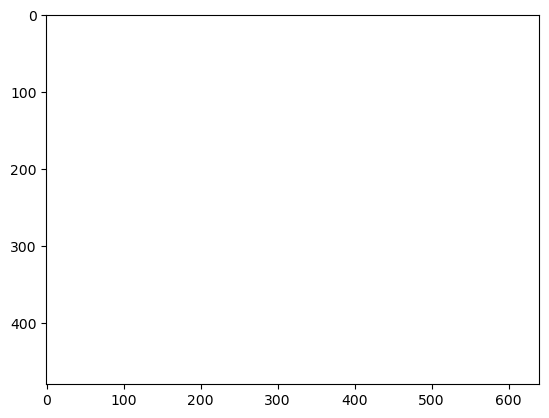

In [27]:
    
x_test[0] = (x_test[0] * 255).astype(np.uint8)
print(x_test[0].shape)
finger_test = our_detection(x_test[0])
if finger_test == y_test[0]:
    correct += 1


In [ ]:
correct = 0
for i in range(len(y_test)):
    
    x_test[i] = (x_test[i] * 255).astype(np.uint8)
    print(x_test[i].shape)
    finger_test = our_detection(x_test[i])
    if finger_test == y_test[i]:
        correct += 1
print(correct)

(480, 640, 3)


error: OpenCV(4.10.0) /home/conda/feedstock_root/build_artifacts/libopencv_1729143266536/work/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [ ]:
def main():
    our_fingers_count = our_detection()
    pre_trained_fingers_count = pre_trained_detection()
    if our_fingers_count == pre_trained_fingers_count:
        print("Right", our_fingers_count)

In [27]:
if __name__ == "__main__":
    main()

INFO:webcam_skin_detection:Webcam opened successfully
INFO:webcam_skin_detection:Fingers detected: 0


middle point [217, 365]
min,max [0, 89, 356, 511]
middle point [217, 365]
min,max [122, 313, 211, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [216, 363]
min,max [0, 101, 381, 511]
middle point [216, 363]
min,max [121, 338, 207, 511]
face shall be removed
middle point [217, 360]
min,max [0, 75, 401, 511]
middle point [217, 360]
min,max [120, 328, 205, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [216, 364]
min,max [320, 370, 167, 411]
middle point [216, 364]
min,max [119, 333, 203, 511]
face shall be removed
middle point [216, 362]
min,max [284, 358, 136, 329]
middle point [216, 362]
min,max [119, 322, 202, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [217, 363]
min,max [310, 352, 161, 391]
middle point [217, 363]
min,max [119, 341, 206, 511]
face shall be removed
middle point [214, 362]
min,max [320, 341, 169, 313]
middle point [214, 362]
min,max [114, 368, 205, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [207, 362]
min,max [83, 102, 274, 346]
middle point [207, 362]
min,max [117, 356, 206, 511]
face shall be removed
middle point [206, 364]
min,max [312, 360, 245, 399]
middle point [206, 364]
min,max [114, 323, 56, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [202, 363]
min,max [119, 154, 126, 209]
middle point [202, 363]
min,max [117, 309, 204, 511]
face shall be removed
middle point [207, 362]
min,max [196, 224, 113, 197]
middle point [207, 362]
min,max [116, 311, 206, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [210, 363]
min,max [2, 27, 431, 511]
middle point [210, 363]
min,max [117, 320, 207, 511]
face shall be removed
middle point [210, 368]
min,max [297, 366, 151, 333]
middle point [210, 368]
min,max [103, 309, 209, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [212, 368]
min,max [340, 360, 280, 409]
middle point [212, 368]
min,max [106, 331, 205, 511]
face shall be removed
middle point [207, 360]
min,max [15, 54, 435, 511]
middle point [207, 360]
min,max [99, 307, 202, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [202, 363]
min,max [311, 342, 214, 332]
middle point [202, 363]
min,max [111, 357, 205, 511]
face shall be removed
middle point [190, 361]
min,max [82, 110, 173, 266]
middle point [190, 361]
min,max [92, 291, 204, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [170, 355]
min,max [51, 77, 327, 435]
middle point [170, 355]
min,max [84, 288, 200, 511]
face shall be removed
middle point [176, 348]
min,max [307, 330, 297, 395]
middle point [176, 348]
min,max [89, 307, 194, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [175, 350]
min,max [149, 175, 111, 190]
middle point [175, 350]
min,max [90, 280, 195, 511]
face shall be removed
middle point [166, 345]
min,max [280, 299, 135, 249]
middle point [166, 345]
min,max [79, 301, 182, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [153, 343]
min,max [127, 146, 114, 175]
middle point [153, 343]
min,max [69, 267, 183, 511]
face shall be removed
middle point [140, 340]
min,max [455, 477, 444, 503]
middle point [140, 340]
min,max [50, 248, 181, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [138, 341]
min,max [18, 45, 157, 282]
middle point [138, 341]
min,max [23, 243, 184, 511]
face shall be removed
middle point [138, 355]
min,max [34, 74, 115, 239]
middle point [138, 355]
min,max [0, 263, 196, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0


middle point [141, 351]
min,max [30, 81, 108, 276]
middle point [141, 351]
min,max [0, 276, 193, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [149, 354]
min,max [0, 53, 372, 511]
middle point [149, 354]
min,max [60, 250, 200, 511]
face shall be removed
middle point [149, 355]
min,max [26, 58, 393, 511]
middle point [149, 355]
min,max [60, 251, 199, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [148, 357]
min,max [151, 167, 104, 162]
middle point [148, 357]
min,max [0, 253, 201, 511]
face shall be removed
middle point [150, 361]
min,max [0, 44, 426, 511]
middle point [150, 361]
min,max [58, 282, 205, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [154, 361]
min,max [0, 56, 421, 511]
middle point [154, 361]
min,max [62, 285, 202, 511]
face shall be removed
middle point [154, 364]
min,max [0, 42, 371, 511]
middle point [154, 364]
min,max [44, 259, 201, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [154, 362]
min,max [165, 181, 102, 177]
middle point [154, 362]
min,max [65, 257, 203, 511]
face shall be removed
middle point [152, 364]
min,max [0, 32, 436, 511]
middle point [152, 364]
min,max [66, 270, 203, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [153, 363]
min,max [273, 314, 156, 412]
middle point [153, 363]
min,max [67, 259, 207, 511]
face shall be removed
middle point [153, 363]
min,max [285, 310, 219, 401]
middle point [153, 363]
min,max [63, 261, 208, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [154, 363]
min,max [129, 157, 114, 190]
middle point [154, 363]
min,max [51, 289, 207, 511]
face shall be removed
middle point [155, 363]
min,max [277, 314, 308, 466]
middle point [155, 363]
min,max [37, 261, 208, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [154, 364]
min,max [255, 280, 155, 218]
middle point [154, 364]
min,max [67, 269, 210, 511]
face shall be removed
middle point [156, 361]
min,max [292, 322, 230, 396]
middle point [156, 361]
min,max [67, 286, 210, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [156, 363]
min,max [65, 99, 114, 210]
middle point [156, 363]
min,max [67, 261, 205, 511]
face shall be removed
middle point [158, 365]
min,max [69, 86, 117, 200]
middle point [158, 365]
min,max [68, 259, 205, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [154, 363]
min,max [0, 63, 418, 511]
middle point [154, 363]
min,max [67, 259, 207, 511]
face shall be removed
middle point [156, 362]
min,max [0, 42, 393, 511]
middle point [156, 362]
min,max [66, 272, 209, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [153, 365]
min,max [71, 102, 109, 212]
middle point [153, 365]
min,max [66, 259, 212, 511]
face shall be removed
middle point [154, 361]
min,max [0, 24, 440, 511]
middle point [154, 361]
min,max [41, 277, 209, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [151, 362]
min,max [251, 319, 138, 331]
middle point [151, 362]
min,max [66, 272, 211, 511]
face shall be removed
middle point [154, 363]
min,max [288, 312, 291, 415]
middle point [154, 363]
min,max [15, 269, 209, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [154, 365]
min,max [290, 314, 265, 400]
middle point [154, 365]
min,max [65, 259, 211, 511]
face shall be removed
middle point [154, 363]
min,max [161, 193, 96, 190]
middle point [154, 363]
min,max [66, 269, 208, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [151, 362]
min,max [26, 64, 419, 511]
middle point [151, 362]
min,max [66, 291, 209, 511]
face shall be removed
middle point [157, 362]
min,max [36, 77, 150, 268]
middle point [157, 362]
min,max [67, 284, 210, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [160, 365]
min,max [26, 58, 262, 432]
middle point [160, 365]
min,max [67, 258, 210, 511]
face shall be removed
middle point [160, 363]
min,max [288, 317, 227, 416]
middle point [160, 363]
min,max [67, 285, 209, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [164, 364]
min,max [255, 299, 162, 225]
middle point [164, 364]
min,max [67, 260, 209, 511]
face shall be removed
middle point [172, 362]
min,max [0, 22, 423, 511]
middle point [172, 362]
min,max [57, 279, 210, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [175, 363]
min,max [193, 245, 121, 196]
middle point [175, 363]
min,max [71, 263, 208, 511]
face shall be removed
middle point [178, 362]
min,max [0, 51, 413, 511]
middle point [178, 362]
min,max [69, 284, 206, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [174, 364]
min,max [0, 66, 320, 511]
middle point [174, 364]
min,max [68, 261, 207, 511]
face shall be removed
middle point [174, 361]
min,max [146, 186, 96, 198]
middle point [174, 361]
min,max [68, 277, 211, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [174, 360]
min,max [265, 296, 132, 240]
middle point [174, 360]
min,max [68, 283, 206, 511]
face shall be removed
middle point [166, 358]
min,max [455, 479, 419, 492]
middle point [166, 358]
min,max [69, 278, 205, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [162, 361]
min,max [77, 93, 113, 208]
middle point [162, 361]
min,max [47, 261, 206, 511]
face shall be removed
middle point [153, 362]
min,max [454, 481, 414, 504]
middle point [153, 362]
min,max [62, 267, 207, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [145, 363]
min,max [35, 51, 190, 247]
middle point [145, 363]
min,max [0, 253, 212, 511]
face shall be removed
middle point [137, 363]
min,max [119, 134, 132, 191]
middle point [137, 363]
min,max [0, 234, 212, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [114, 367]
min,max [375, 511, 410, 511]
middle point [114, 367]
min,max [0, 210, 214, 511]
face shall be removed
middle point [114, 367]
min,max [333, 511, 356, 511]
middle point [114, 367]
min,max [0, 205, 216, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [322, 511, 296, 511]
middle point [114, 367]
min,max [0, 199, 224, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [314, 511, 260, 511]
middle point [114, 367]
min,max [0, 205, 212, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [0, 165, 237, 511]
face shall be removed
middle point [114, 367]
min,max [303, 511, 233, 511]
middle point [114, 367]
min,max [0, 178, 229, 511]
face shall be removed
middle point [114, 367]
min,max [300, 511, 215, 511]


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 3


middle point [114, 367]
min,max [0, 176, 233, 511]
face shall be removed
middle point [114, 367]
min,max [300, 511, 194, 511]
middle point [114, 367]
min,max [0, 152, 244, 511]
face shall be removed
middle point [114, 367]
min,max [298, 511, 152, 511]


INFO:webcam_skin_detection:Fingers detected: 3
INFO:webcam_skin_detection:Fingers detected: 5


middle point [114, 367]
min,max [0, 155, 248, 511]
face shall be removed
middle point [114, 367]
min,max [290, 511, 117, 511]
middle point [114, 367]
min,max [0, 155, 240, 511]
face shall be removed
middle point [114, 367]
min,max [286, 511, 94, 511]


INFO:webcam_skin_detection:Fingers detected: 5
INFO:webcam_skin_detection:Fingers detected: 5


middle point [114, 367]
min,max [0, 162, 240, 511]
face shall be removed
middle point [114, 367]
min,max [286, 511, 87, 511]
middle point [114, 367]
min,max [0, 156, 244, 511]
face shall be removed
middle point [114, 367]
min,max [287, 511, 89, 511]


INFO:webcam_skin_detection:Fingers detected: 6
INFO:webcam_skin_detection:Fingers detected: 6


middle point [114, 367]
min,max [0, 163, 246, 511]
face shall be removed
middle point [114, 367]
min,max [290, 511, 93, 511]
middle point [114, 367]
min,max [0, 184, 235, 511]
face shall be removed
middle point [114, 367]
min,max [292, 511, 98, 511]


INFO:webcam_skin_detection:Fingers detected: 5
INFO:webcam_skin_detection:Fingers detected: 4


middle point [114, 367]
min,max [0, 165, 246, 511]
face shall be removed
middle point [114, 367]
min,max [295, 511, 104, 511]
middle point [114, 367]
min,max [0, 167, 240, 511]
face shall be removed
middle point [114, 367]
min,max [296, 511, 85, 511]


INFO:webcam_skin_detection:Fingers detected: 4
INFO:webcam_skin_detection:Fingers detected: 4


middle point [114, 367]
min,max [0, 192, 199, 511]
face shall be removed
middle point [114, 367]
min,max [296, 511, 112, 511]
middle point [114, 367]
min,max [0, 183, 246, 511]
face shall be removed
middle point [114, 367]
min,max [295, 511, 89, 511]


INFO:webcam_skin_detection:Fingers detected: 5
INFO:webcam_skin_detection:Fingers detected: 4


middle point [114, 367]
min,max [0, 192, 246, 511]
face shall be removed
middle point [114, 367]
min,max [295, 511, 113, 511]
middle point [114, 367]
min,max [0, 183, 238, 511]
face shall be removed
middle point [114, 367]
min,max [293, 511, 111, 511]


INFO:webcam_skin_detection:Fingers detected: 4
INFO:webcam_skin_detection:Fingers detected: 5


middle point [114, 367]
min,max [0, 161, 245, 511]
face shall be removed
middle point [114, 367]
min,max [293, 511, 113, 511]
middle point [114, 367]
min,max [0, 163, 235, 511]
face shall be removed
middle point [114, 367]
min,max [291, 511, 113, 511]


INFO:webcam_skin_detection:Fingers detected: 4
INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [0, 165, 244, 511]
face shall be removed
middle point [114, 367]
min,max [318, 511, 144, 511]
middle point [114, 367]
min,max [0, 164, 197, 511]
face shall be removed
middle point [114, 367]
min,max [306, 511, 155, 511]


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 160, 238, 511]
face shall be removed
middle point [114, 367]
min,max [305, 511, 154, 511]
middle point [114, 367]
min,max [304, 511, 155, 511]
middle point [114, 367]
min,max [0, 179, 198, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [305, 511, 153, 511]
middle point [114, 367]
min,max [0, 206, 240, 511]
face shall be removed
middle point [114, 367]
min,max [0, 165, 236, 511]
face shall be removed
middle point [114, 367]
min,max [306, 511, 153, 511]


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 159, 248, 511]
face shall be removed
middle point [114, 367]
min,max [308, 511, 153, 511]
middle point [114, 367]
min,max [0, 167, 238, 511]
face shall be removed
middle point [114, 367]
min,max [309, 511, 153, 511]


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [0, 165, 246, 511]
face shall be removed
middle point [114, 367]
min,max [309, 511, 153, 511]
middle point [114, 367]
min,max [0, 192, 247, 511]
face shall be removed
middle point [114, 367]
min,max [309, 511, 153, 511]


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 159, 248, 511]
face shall be removed
middle point [114, 367]
min,max [309, 511, 147, 511]
middle point [114, 367]
min,max [0, 180, 246, 511]
face shall be removed
middle point [114, 367]
min,max [312, 511, 132, 511]


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 160, 248, 511]
face shall be removed
middle point [114, 367]
min,max [314, 511, 122, 511]
middle point [114, 367]
min,max [0, 182, 230, 511]
face shall be removed
middle point [114, 367]
min,max [317, 511, 112, 511]


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 168, 240, 511]
face shall be removed
middle point [114, 367]
min,max [320, 511, 109, 511]
middle point [114, 367]
min,max [0, 180, 246, 511]
face shall be removed
middle point [114, 367]
min,max [326, 511, 108, 511]


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 169, 243, 511]
face shall be removed
middle point [114, 367]
min,max [336, 511, 102, 511]
middle point [114, 367]
min,max [0, 182, 244, 511]
face shall be removed
middle point [114, 367]
min,max [346, 511, 100, 511]


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 165, 255, 511]
face shall be removed
middle point [114, 367]
min,max [357, 511, 100, 511]
middle point [114, 367]
min,max [365, 511, 102, 511]
middle point [114, 367]
min,max [0, 184, 246, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [378, 511, 104, 511]
middle point [114, 367]
min,max [0, 172, 248, 511]
face shall be removed
middle point [114, 367]
min,max [359, 511, 107, 511]
middle point [114, 367]
min,max [0, 184, 248, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [397, 511, 115, 511]
middle point [114, 367]
min,max [0, 173, 248, 511]
face shall be removed
middle point [114, 367]
min,max [398, 511, 119, 511]
middle point [114, 367]
min,max [0, 194, 229, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [386, 511, 131, 511]
middle point [114, 367]
min,max [0, 191, 241, 511]
face shall be removed
middle point [114, 367]
min,max [393, 511, 141, 511]
middle point [114, 367]
min,max [0, 188, 242, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [421, 511, 153, 511]
middle point [114, 367]
min,max [2, 178, 250, 511]
face shall be removed
middle point [114, 367]
min,max [374, 511, 161, 511]
middle point [114, 367]
min,max [0, 181, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [413, 511, 168, 511]
middle point [114, 367]
min,max [0, 178, 238, 511]
face shall be removed
middle point [114, 367]
min,max [407, 511, 177, 511]
middle point [114, 367]
min,max [0, 191, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 3
INFO:webcam_skin_detection:Fingers detected: 3


middle point [114, 367]
min,max [399, 511, 186, 511]
middle point [114, 367]
min,max [5, 184, 252, 511]
face shall be removed
middle point [114, 367]
min,max [394, 511, 196, 511]
middle point [114, 367]
min,max [18, 173, 252, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [381, 511, 203, 511]
middle point [114, 367]
min,max [17, 173, 253, 511]
face shall be removed
middle point [114, 367]
min,max [390, 511, 200, 511]
middle point [114, 367]
min,max [21, 175, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [391, 511, 197, 511]
middle point [114, 367]
min,max [0, 200, 240, 511]
face shall be removed
middle point [114, 367]
min,max [393, 511, 189, 511]
middle point [114, 367]
min,max [0, 213, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [392, 511, 186, 511]
middle point [114, 367]
min,max [3, 180, 253, 511]
face shall be removed
middle point [114, 367]
min,max [389, 511, 182, 511]
middle point [114, 367]
min,max [0, 197, 241, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [362, 511, 182, 511]
middle point [114, 367]
min,max [0, 190, 246, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [388, 511, 182, 511]
middle point [114, 367]
min,max [0, 193, 239, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [388, 511, 183, 511]
middle point [114, 367]
min,max [0, 200, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [386, 511, 184, 511]
middle point [114, 367]
min,max [20, 176, 247, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [388, 511, 179, 511]
middle point [114, 367]
min,max [27, 176, 247, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [388, 511, 174, 511]
middle point [114, 367]
min,max [0, 189, 240, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [383, 511, 168, 511]
middle point [114, 367]
min,max [0, 227, 177, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 3


middle point [114, 367]
min,max [381, 511, 157, 511]
middle point [114, 367]
min,max [19, 175, 250, 511]
face shall be removed
middle point [114, 367]
min,max [378, 511, 153, 511]
middle point [114, 367]
min,max [0, 175, 245, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [351, 511, 147, 511]
middle point [114, 367]
min,max [0, 189, 244, 511]
face shall be removed
middle point [114, 367]
min,max [378, 511, 143, 511]
middle point [114, 367]
min,max [0, 181, 246, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [29, 175, 248, 511]
face shall be removed
middle point [114, 367]
min,max [371, 511, 131, 511]
middle point [114, 367]
min,max [11, 177, 249, 511]
face shall be removed
middle point [114, 367]
min,max [368, 511, 124, 511]


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [366, 511, 118, 511]
middle point [114, 367]
min,max [0, 200, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 3


middle point [114, 367]
min,max [15, 181, 247, 511]
face shall be removed
middle point [114, 367]
min,max [367, 511, 114, 511]
middle point [114, 367]
min,max [366, 511, 110, 511]
middle point [114, 367]
min,max [0, 183, 195, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [365, 511, 108, 511]
middle point [114, 367]
min,max [0, 181, 247, 511]
face shall be removed
middle point [114, 367]
min,max [363, 511, 104, 511]
middle point [114, 367]
min,max [0, 190, 251, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 178, 245, 511]
face shall be removed
middle point [114, 367]
min,max [362, 511, 103, 511]
middle point [114, 367]
min,max [363, 511, 103, 511]
middle point [114, 367]
min,max [0, 178, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [363, 511, 105, 511]
middle point [114, 367]
min,max [0, 183, 244, 511]
face shall be removed
middle point [114, 367]
min,max [348, 511, 106, 511]
middle point [114, 367]
min,max [0, 182, 240, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 183, 243, 511]
face shall be removed
middle point [114, 367]
min,max [364, 511, 107, 511]
middle point [114, 367]
min,max [364, 511, 107, 511]
middle point [114, 367]
min,max [0, 189, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [365, 511, 109, 511]
middle point [114, 367]
min,max [0, 195, 235, 511]
face shall be removed
middle point [114, 367]
min,max [23, 183, 248, 511]
face shall be removed
middle point [114, 367]
min,max [365, 511, 109, 511]


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [0, 187, 247, 511]
face shall be removed
middle point [114, 367]
min,max [348, 511, 109, 511]
middle point [114, 367]
min,max [366, 511, 110, 511]
middle point [114, 367]
min,max [0, 187, 242, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [343, 511, 112, 511]
middle point [114, 367]
min,max [0, 201, 240, 511]
face shall be removed
middle point [114, 367]
min,max [366, 511, 115, 511]
middle point [114, 367]
min,max [0, 212, 245, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [363, 511, 121, 511]
middle point [114, 367]
min,max [0, 179, 246, 511]
face shall be removed
middle point [114, 367]
min,max [362, 511, 128, 511]
middle point [114, 367]
min,max [0, 192, 212, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [359, 511, 134, 511]
middle point [114, 367]
min,max [0, 210, 247, 511]
face shall be removed
middle point [114, 367]
min,max [357, 511, 143, 511]
middle point [114, 367]
min,max [0, 192, 140, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [356, 511, 153, 511]
middle point [114, 367]
min,max [7, 182, 255, 511]
face shall be removed
middle point [114, 367]
min,max [353, 511, 159, 511]
middle point [114, 367]
min,max [0, 199, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [27, 181, 248, 511]
face shall be removed
middle point [114, 367]
min,max [348, 511, 166, 511]
middle point [114, 367]
min,max [12, 173, 252, 511]
face shall be removed
middle point [114, 367]
min,max [347, 511, 170, 511]


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [342, 511, 182, 511]
middle point [114, 367]
min,max [0, 200, 212, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [334, 511, 190, 511]
middle point [114, 367]
min,max [0, 215, 239, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [333, 511, 199, 511]
middle point [114, 367]
min,max [0, 177, 239, 511]
face shall be removed
middle point [114, 367]
min,max [331, 511, 206, 511]
middle point [114, 367]
min,max [0, 202, 156, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [328, 511, 216, 511]
middle point [114, 367]
min,max [0, 194, 244, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [325, 511, 232, 511]
middle point [114, 367]
min,max [0, 206, 245, 511]
face shall be removed
middle point [114, 367]
min,max [316, 511, 253, 511]
middle point [114, 367]
min,max [0, 200, 245, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2
INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [309, 511, 266, 511]
middle point [114, 367]
min,max [0, 178, 247, 511]
face shall be removed
middle point [114, 367]
min,max [298, 511, 280, 511]
middle point [114, 367]
min,max [7, 175, 245, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [287, 511, 295, 511]
middle point [114, 367]
min,max [0, 200, 239, 511]
face shall be removed
middle point [114, 367]
min,max [284, 501, 314, 511]
middle point [114, 367]
min,max [0, 181, 246, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [114, 367]
min,max [299, 511, 341, 511]
middle point [114, 367]
min,max [0, 181, 248, 511]
face shall be removed
middle point [114, 367]
min,max [305, 511, 344, 511]
middle point [114, 367]
min,max [0, 200, 240, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [114, 367]
min,max [304, 511, 342, 511]
middle point [114, 367]
min,max [0, 216, 246, 511]
face shall be removed
middle point [114, 367]
min,max [300, 511, 342, 511]
middle point [114, 367]
min,max [0, 192, 201, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1


middle point [114, 367]
min,max [305, 505, 345, 511]
middle point [114, 367]
min,max [12, 178, 248, 511]
face shall be removed
middle point [114, 367]
min,max [304, 511, 348, 511]
middle point [114, 367]
min,max [18, 181, 248, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 1
INFO:webcam_skin_detection:Fingers detected: 0
INFO:webcam_skin_detection:Fingers detected: 0


middle point [114, 367]
min,max [308, 511, 345, 511]
middle point [114, 367]
min,max [0, 200, 246, 511]
face shall be removed
middle point [114, 367]
min,max [309, 511, 344, 511]
middle point [114, 367]
min,max [0, 181, 248, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 2


middle point [114, 367]
min,max [309, 511, 339, 511]
middle point [114, 367]
min,max [0, 199, 244, 511]
face shall be removed
middle point [114, 367]
min,max [292, 511, 286, 511]
middle point [114, 367]
min,max [0, 200, 239, 511]
face shall be removed


INFO:webcam_skin_detection:Fingers detected: 3
INFO:webcam_skin_detection:Fingers detected: 4


middle point [114, 367]
min,max [284, 504, 244, 511]
middle point [114, 367]
min,max [2, 186, 158, 511]
face shall be removed
middle point [114, 367]
min,max [31, 187, 246, 511]
face shall be removed
middle point [114, 367]
min,max [282, 511, 224, 511]


INFO:webcam_skin_detection:Fingers detected: 4
INFO:webcam_skin_detection:Fingers detected: 4


middle point [114, 367]
min,max [0, 241, 235, 511]
face shall be removed
middle point [114, 367]
min,max [279, 510, 212, 511]


INFO:webcam_skin_detection:Fingers detected: 4


middle point [114, 367]
min,max [12, 203, 237, 511]
face shall be removed
middle point [114, 367]
min,max [277, 508, 214, 511]


INFO:webcam_skin_detection:Fingers detected: 4


middle point [114, 367]
min,max [0, 237, 237, 511]
face shall be removed
middle point [114, 367]
min,max [276, 506, 214, 511]
middle point [114, 367]
min,max [5, 238, 235, 511]
face shall be removed
middle point [114, 367]
min,max [272, 501, 214, 511]


INFO:webcam_skin_detection:Fingers detected: 4
INFO:webcam_skin_detection:Webcam released and windows closed
